<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Load-all-HLA" data-toc-modified-id="Load-all-HLA-5">Load all HLA</a></span></li><li><span><a href="#Merge-with-metadata" data-toc-modified-id="Merge-with-metadata-6">Merge with metadata</a></span></li><li><span><a href="#Allele-frequencies-for-HLA-types" data-toc-modified-id="Allele-frequencies-for-HLA-types-7">Allele frequencies for HLA types</a></span></li><li><span><a href="#Most-common-HLAs-across-immune-clusters" data-toc-modified-id="Most-common-HLAs-across-immune-clusters-8">Most common HLAs across immune clusters</a></span></li><li><span><a href="#Stats" data-toc-modified-id="Stats-9">Stats</a></span></li><li><span><a href="#Stats-HLAs-across-cohorts" data-toc-modified-id="Stats-HLAs-across-cohorts-10">Stats HLAs across cohorts</a></span></li><li><span><a href="#HLA-vs-mutations" data-toc-modified-id="HLA-vs-mutations-11">HLA vs mutations</a></span><ul class="toc-item"><li><span><a href="#Get-nonsyn-variants" data-toc-modified-id="Get-nonsyn-variants-11.1">Get nonsyn variants</a></span><ul class="toc-item"><li><span><a href="#CBTTC" data-toc-modified-id="CBTTC-11.1.1">CBTTC</a></span></li><li><span><a href="#DKFZ" data-toc-modified-id="DKFZ-11.1.2">DKFZ</a></span></li><li><span><a href="#TARGET" data-toc-modified-id="TARGET-11.1.3">TARGET</a></span></li></ul></li><li><span><a href="#All-nonsyn-mutated-genes" data-toc-modified-id="All-nonsyn-mutated-genes-11.2">All nonsyn mutated genes</a></span></li></ul></li></ul></div>

# Dependencies

In [1]:
options(scipen = 999)

In [2]:
library(dplyr)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




# Functions


In [3]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")
source("~/OneDrive - UHN/R_src/color_schemes.R")
source("~/OneDrive - UHN/R_src/Heatmap_functions.R")
source("~/OneDrive - UHN/R_src/Oncoprint_functions.R")

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.12
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [4]:
HLA_freq_plot <- function(metadata, hlatype1, hlatype2, title){
    
    myalleles <- c(metadata[[hlatype1]],metadata[[hlatype2]])
    Tab_Freq <- as.data.frame(table(myalleles), stringsAsFactors = F)
    Tab_Freq$AF <- Tab_Freq$Freq/(2*904)
    Tab_Freq <- Tab_Freq[order(Tab_Freq$AF, decreasing = T),]
    Tab_Freq$myalleles <- gsub(".*[*]", "", Tab_Freq$myalleles)
    Tab_Freq$myalleles <- factor(Tab_Freq$myalleles,levels = Tab_Freq$myalleles)

    AF_plot <- ggplot(Tab_Freq, aes(x = myalleles, y = AF)) +  
    geom_bar(stat = "identity") + myplot + 
    theme(axis.title.y = element_text(size = 45),
          axis.title.x = element_blank(),
          axis.line = element_line(color = "black"),
          axis.text.x = element_text(size = 30, angle = 45, hjust = 1, color = "black"),
          axis.text.y = element_text(size = 30, color = "black")) +
    labs(y = paste0("Allele frequency", title))
    
    return(AF_plot)
    }

# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

In [6]:
mountpath <- "/Users/anabbi/Desktop/H4H/immpedcan/antigen_prediction/HLAtyping/"

# Main

In [7]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [8]:
table(metadata_IC$immune_cluster)


Pediatric inflamed     Myeloid-driven     Pediatric cold    Immune excluded 
                90                279                393                163 

In [9]:
allfiles <- list.files(mountpath, pattern = ".tsv", full.names = T, recursive = T)

In [10]:
# remove abundance files
allfiles <- allfiles[!grepl("abundance", allfiles)]

In [11]:
all.files <- lapply(allfiles, 
                    function(f){read.table(f, header = TRUE, sep = "\t", 
                                           stringsAsFactors = F, nrows = 1, row.names = 1)})

In [12]:
myfilesnames <- allfiles

In [13]:
names(all.files) <- gsub(".*HLAtyping//", "", myfilesnames)
names(all.files) <- gsub(".result.tsv", "", names(all.files))

In [14]:
# cleanup filenames from ICGC
names(all.files) <- gsub(".*view-by-pid/", "", names(all.files))

names(all.files) <- gsub("/2020_0.*", "", names(all.files))

names(all.files) <- gsub("Optitype_ICGC/", "", names(all.files))

names(all.files) <- gsub("/", "", names(all.files))

In [15]:
head(all.files)

named list()

replace PIDs to ICGC sample_ids

In [39]:
ICGC_map <- read.csv(file = paste0(datapath, "HLA/MB_ICGCid_pid_Map4HLAtype_ICGC.csv"),
                        check.names = F, header = TRUE, stringsAsFactors = FALSE)

In [40]:
head(ICGC_map)

,SampleID_ICGC,PID
,<chr>,<chr>
1,ICGC_MB1,179743
2,ICGC_MB2,198274
3,ICGC_MB3,MBBL3
4,ICGC_MB4,NA
5,ICGC_MB5,122372
6,ICGC_MB6,163298


In [41]:
pids <- c('104328','107430','108031','119591','127581',
          '128398','138689','165133','167702','177904',
          '181633','185985','186723','196865')

In [42]:
ICGC_map <- ICGC_map[ ICGC_map$PID %in% pids,]

In [43]:
ICGC_map

,SampleID_ICGC,PID
,<chr>,<chr>
19,ICGC_MB19,138689
28,ICGC_MB28,186723
31,ICGC_MB31,128398
34,ICGC_MB34,185985
39,ICGC_MB39,107430
40,ICGC_MB40,127581
53,ICGC_MB53,108031
57,ICGC_MB57,165133
58,ICGC_MB58,167702


In [44]:
names(all.files)[match(ICGC_map$PID,names(all.files))] <- ICGC_map$SampleID_ICGC

bind all together

In [45]:
all.hla <- do.call("rbind", all.files)

In [46]:
all.hla$sample_id <- rep(names(all.files), sapply(all.files, nrow))

In [47]:
head(all.hla)

,A1,A2,B1,B2,C1,C2,Reads,Objective,sample_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
7316-10,A*03:01,A*23:01,B*44:03,B*58:02,C*06:02,C*14:03,24704,24036.992,7316-10
7316-100,A*33:03,A*03:01,B*56:01,B*18:01,C*02:02,C*01:02,16524,16077.852,7316-100
7316-101,A*29:02,A*33:03,B*35:01,B*15:03,C*02:10,C*07:01,11633,11318.909,7316-101
7316-1038,A*03:01,A*68:02,B*14:02,B*52:01,C*03:03,C*08:02,9172,8924.356,7316-1038
7316-104,A*34:01,A*24:02,B*51:01,B*40:01,C*04:01,C*04:01,10682,10489.724,7316-104
7316-1052,A*11:01,A*02:02,B*15:01,B*41:01,C*17:01,C*03:03,21807,21218.211,7316-1052


In [48]:
save(all.hla, file = paste0(datapath, "HLA/all.hla.RData"))

# Load all HLA

# Merge with metadata

In [16]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [17]:
load(file = paste0(datapath, "HLA/all.hla.RData"))

In [18]:
dim(all.hla)

[1] 1405    9

In [19]:
metadata_IC_HLA <- merge(metadata_IC, all.hla, by = "sample_id")

In [20]:
dim(metadata_IC_HLA)

[1] 904  32

In [21]:
write.csv(metadata_IC_HLA[,c("sample_id", 'A1','A2','B1','B2','C1','C2')],
         file = paste0(datapath, "forGangesh/hla.csv"), row.names = F)

# Allele frequencies for HLA types

In [22]:
HLA_A_plot <- HLA_freq_plot(metadata_IC_HLA, "A1", "A2", " (HLA-A)")

In [23]:
HLA_B_plot <- HLA_freq_plot(metadata_IC_HLA, "B1", "B2", " (HLA-B)")

In [24]:
HLA_C_plot <- HLA_freq_plot(metadata_IC_HLA, "C1", "C2", " (HLA-C)")

In [25]:
pdf(paste0(plotpath, "HLA_A_plot.pdf"),
   width = 45, height = 15)
HLA_A_plot
dev.off()

pdf 
  2

In [26]:
pdf(paste0(plotpath, "HLA_B_plot.pdf"),
   width = 45, height = 15)
HLA_B_plot
dev.off()

pdf 
  2

In [27]:
pdf(paste0(plotpath, "HLA_C_plot.pdf"),
   width = 45, height = 15)
HLA_C_plot
dev.off()

pdf 
  2

# Most common HLAs across immune clusters

In [100]:
HLA_tab.fx <- function(metadata, HLA1, HLA2, HLA){

myalleles <- c(metadata[[HLA1]], metadata[[HLA2]])
Tab_Freq <- as.data.frame(table(myalleles), stringsAsFactors = F)
Tab_Freq$AF <- Tab_Freq$Freq/(2*904)
Tab_Freq <- Tab_Freq[order(Tab_Freq$AF, decreasing = T),]

common_hlas <- Tab_Freq$myalleles[ Tab_Freq$AF > 0.02]
    
 
tmp1 <- metadata[,c("immune_cluster", HLA1)]
tmp2 <- metadata[,c("immune_cluster", HLA2)]
colnames(tmp1)[2] <- HLA  
colnames(tmp2)[2] <- HLA     
    
tmp <- rbind(tmp1, tmp2)    
    
tmp <- tmp[ tmp[[HLA]] %in% common_hlas,]
    
myhla_tab <- as.data.frame(prop.table(table(tmp[["immune_cluster"]], tmp[[HLA]]), margin = 2),
                       stringsAsFactors = F)
  
    
 return(myhla_tab)   
    
    }

In [101]:
HLA_A_tab <- HLA_tab.fx(metadata_IC_HLA, "A1", "A2", "A")

HLA_B_tab <- HLA_tab.fx(metadata_IC_HLA, "B1", "B2", "B")

HLA_C_tab <- HLA_tab.fx(metadata_IC_HLA, "C1", "C2", "C")

In [102]:
HLA_B_tab <- rbind(c("EMPTY","EMPTY", 0.00), HLA_B_tab)

HLA_C_tab <- rbind(c("EMPTY","EMPTY1", 0.00), HLA_C_tab)

In [103]:
HLA_tab <- rbind(HLA_A_tab, HLA_B_tab, HLA_C_tab)

In [104]:
HLA_tab$Var1 <- factor(HLA_tab$Var1, levels = c("EMPTY","Pediatric inflamed", "Myeloid-driven",
                                                "Pediatric cold", "Immune excluded"))

In [105]:
HLA_tab$Freq <- as.numeric(HLA_tab$Freq)

In [106]:
HLA_tab$Var2 <- factor(HLA_tab$Var2, levels = unique(HLA_tab$Var2))

In [108]:
rmEMPTY <- rep("black",length(levels(HLA_tab$Var2)))
rmEMPTY[c(which(levels(HLA_tab$Var2) == "EMPTY"), 
          which(levels(HLA_tab$Var2) == "EMPTY1"))] <- "white"

In [153]:
HLA_plot_IC <- ggplot() +  
    geom_bar(data = HLA_tab, aes(x = Var2, y = Freq, fill = Var1), stat = "identity") + 
    scale_fill_manual(values = c("EMPTY" = "white", cluster_col)) + 
    myplot + myaxis +
    theme(axis.title.x = element_blank(), 
          axis.text.x = element_text(size = 35, color = rmEMPTY),
          axis.text.y = element_text(size = 35),
          axis.title.y = element_blank(),
          legend.position = "none",
          plot.title = element_text(hjust = 0.5, size = 35)) 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


Add significance asterisks

In [155]:
label.df <- data.frame(x = c("A*02:01", "C*03:04"), y = c(1,1))
HLA_plot_IC <- HLA_plot_IC + 
geom_text(data = label.df, aes(x = x, y = y), label = "*", size = 20)

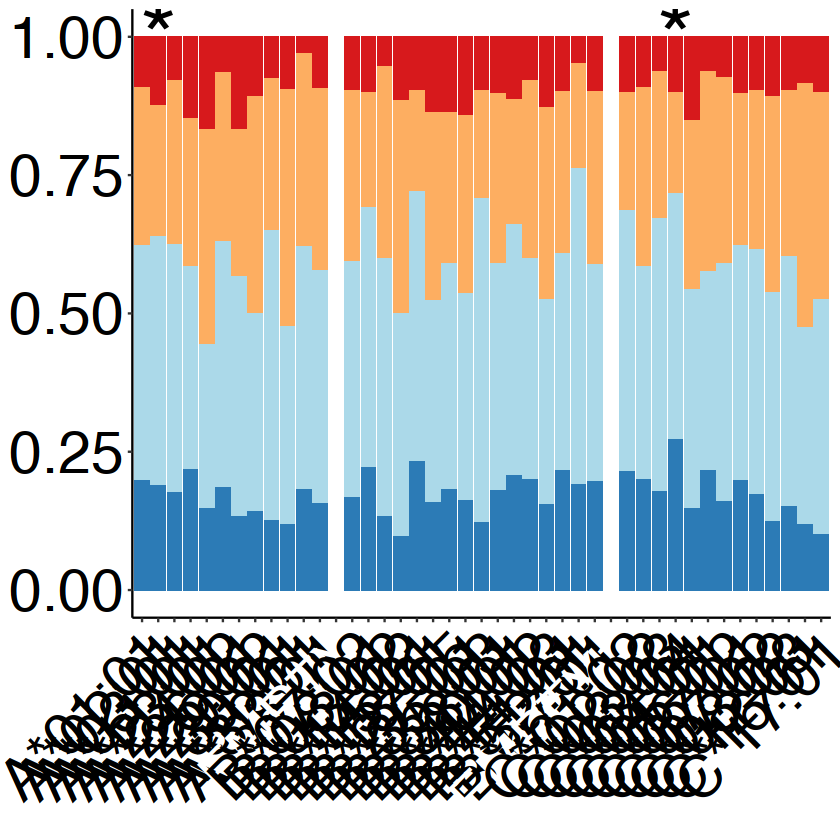

In [156]:
HLA_plot_IC

In [157]:
pdf(paste0(plotpath, "HLA_plot_IC.pdf"),
   width = 20, height = 10)
HLA_plot_IC  + ggtitle(~underline("HLAs > 2%"))
dev.off()

pdf 
  2

Legends

In [133]:
tmp <- HLA_tab[1:4,]

In [134]:
tmp$Var1 <- factor(tmp$Var1, levels = c("Pediatric inflamed", "Myeloid-driven",
                                        "Pediatric cold", "Immune excluded"))

In [135]:
IC_legend_plot <- ggplot(data = tmp) + 
    geom_bar(aes(x = Var2, y = Freq, fill = Var1), stat = "identity") +
    scale_fill_manual(values =  cluster_col) + theme(legend.title = element_blank())

In [136]:
legend <- cowplot::get_legend(IC_legend_plot)

grid.newpage()
grid.draw(legend)

In [140]:
pdf(paste0(plotpath, "IC_legend.pdf"),
   width = 5, height = 5)
#grid.newpage()
grid.draw(legend)
dev.off()

pdf 
  2

# Stats

In [144]:
stats.fx <- function(metadata, HLA1, HLA2){

myalleles <- c(metadata[[HLA1]], metadata[[HLA2]])
Tab_Freq <- as.data.frame(table(myalleles), stringsAsFactors = F)
Tab_Freq$AF <- Tab_Freq$Freq/(2*904)
Tab_Freq <- Tab_Freq[order(Tab_Freq$AF, decreasing = T),]

common_hlas <- Tab_Freq$myalleles[ Tab_Freq$AF > 0.02]
    
for(hla in common_hlas){
 
    tmp <- metadata
    tmp$myHLA <- NA
tmp$myHLA[ tmp[[HLA1]] == hla] <- 1
tmp$myHLA[ tmp[[HLA2]] == hla] <- 1
tmp$myHLA[ is.na(tmp$myHLA)] <- 0
    
#   print(table(tmp$myHLA)) 
#    message("lrm")
#    print(rms::lrm(myHLA ~ immune_cluster + cohort, data = tmp))
    
if(chisq.test(table(tmp$immune_cluster, tmp$myHLA))$p.value < 0.05){
    message(paste0(hla))  }  
}
    } 
    

In [145]:
stats.fx(metadata_IC_HLA, "C1", "C2")

C*03:04

Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”


In [146]:
stats.fx(metadata_IC_HLA, "B1", "B2")

Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”


In [147]:
stats.fx(metadata_IC_HLA, "A1", "A2")

A*02:01

Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$immune_cluster, tmp$myHLA)):
“Chi-squared approximation may be incorrect”


# 

# Stats HLAs across cohorts

In [261]:
myalleles <- c(metadata_IC_HLA[["B1"]], metadata_IC_HLA[["B2"]])
Tab_Freq <- as.data.frame(table(myalleles), stringsAsFactors = F)
Tab_Freq$AF <- Tab_Freq$Freq/(2*904)
Tab_Freq <- Tab_Freq[order(Tab_Freq$AF, decreasing = T),]

common_hlas <- Tab_Freq$myalleles[ Tab_Freq$AF > 0.02]


In [262]:
for(hla in common_hlas){

    tmp <- metadata_IC_HLA
    tmp$myHLA <- NA
    tmp$myHLA[ tmp[["B1"]] == hla] <- 1
    tmp$myHLA[ tmp[["B2"]] == hla] <- 1
    tmp$myHLA[ is.na(tmp$myHLA)] <- 0
     
    for(c in unique(tmp$cohort)){

        tmp$mycancer <- NA
        tmp$mycancer[ tmp$cohort == c] <- 1
        tmp$mycancer[ is.na(tmp$mycancer)] <- 0      
        if(chisq.test(table(tmp$mycancer, tmp$myHLA))$p.value < 0.05)
            message(c(c,hla))
    }
    }

Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.tes

Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(tmp$mycancer, tmp$myHLA)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.tes

# HLA vs mutations

In [8]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [9]:
load(file = paste0(datapath, "HLA/all.hla.RData"))

In [10]:
dim(all.hla)

[1] 1405    9

In [11]:
metadata_IC_HLA <- merge(metadata_IC, all.hla, by = "sample_id")

In [29]:
load(file = paste0(datapath,"snv/total_mut_manifest_estimate.RData"))

In [30]:
ped_tmb <- total_mut_manifest_estimate[ total_mut_manifest_estimate$group != "TCGA",]

In [31]:
ped_tmb_IC <- merge(ped_tmb, metadata_IC[,c("sample_id", "immune_cluster")], by = "sample_id")

## Get nonsyn variants

### CBTTC

In [32]:
CBTTC_mafsummary <- read.table(file = paste0(datapath, "snv/CBTTC_mafsummary_overlapped_3VAF.txt"),
                        sep = "\t", check.names = F,
                        header = TRUE, stringsAsFactors = FALSE)

In [33]:
dim(CBTTC_mafsummary)

[1] 796  10

In [34]:
library(maftools)

In [35]:
mymaf_CBTTC <- read.maf(maf =  paste0(datapath, "snv/CBTTC_maf_overlapped_3VAF.maf"),
                      useAll = TRUE, verbose = FALSE,
                      vc_nonSyn = c("Frame_Shift_Del", "Frame_Shift_Ins", 
                                    "Nonsense_Mutation","Nonstop_Mutation", 
                                    "In_Frame_Del","In_Frame_Ins", 
                                    "Missense_Mutation"))

In [36]:
mymaf_CBTTC@summary

ID,summary,Mean,Median
<chr>,<chr>,<dbl>,<dbl>
NCBI_Build,GRCh38,NA,NA
Center,Mutect2,NA,NA
Samples,842,NA,NA
nGenes,13511,NA,NA
Frame_Shift_Del,845,1.004,0
Frame_Shift_Ins,769,0.913,0
In_Frame_Del,160,0.190,0
In_Frame_Ins,30,0.036,0
Missense_Mutation,50771,60.298,4


In [37]:
CBTTC_data_maf <- mymaf_CBTTC@data

calculate tumour VAF

In [38]:
CBTTC_data_maf$t_VAF <- CBTTC_data_maf$t_alt_count / CBTTC_data_maf$t_depth

In [39]:
summary(CBTTC_data_maf$t_VAF)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03125 0.23913 0.32468 0.31363 0.39216 1.00000 

In [40]:
CBTTC_data_maf$Tumor_Sample_Barcode <- as.character(CBTTC_data_maf$Tumor_Sample_Barcode)

In [41]:
table(CBTTC_data_maf$Variant_Classification)


  Frame_Shift_Del   Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
              845               769               160                30 
Missense_Mutation Nonsense_Mutation  Nonstop_Mutation 
            50771              2840                25 

In [42]:
CBTTC_data_maf_sampleid <- merge(CBTTC_mafsummary[,c("sample_id", "Tumor_Sample_Barcode")], 
                                 CBTTC_data_maf, by = "Tumor_Sample_Barcode")

In [43]:
length(unique(CBTTC_data_maf_sampleid$Tumor_Sample_Barcode))

[1] 796

Subset  snv dfs to include only samples in estimate df

In [44]:
CBTTC_data_maf <- CBTTC_data_maf_sampleid[CBTTC_data_maf_sampleid$sample_id %in% ped_tmb_IC$sample_id,]

In [45]:
length(unique(CBTTC_data_maf$Tumor_Sample_Barcode))

[1] 470

In [46]:
CBTTC_data_maf_kb <- CBTTC_data_maf[grepl("oncogenic", CBTTC_data_maf$oncogenic,ignore.case = T),]

### DKFZ

In [47]:
DKFZ_maf <- read.table(file = paste0(datapath, "snv/dkfz_mafKB.maf"),
                        sep = "\t", check.names = F,
                        header = TRUE, comment.char = "",stringsAsFactors = FALSE)

In [48]:
table(DKFZ_maf$variant_classification)


    frameshift deletion    frameshift insertion  nonframeshift deletion 
                    600                     330                     150 
nonframeshift insertion       nonsynonymous SNV                splicing 
                     42                   18871                      59 
               stopgain            stopgain SNV            stoploss SNV 
                     16                    1222                       4 
         synonymous SNV 
                    424 

In [49]:
DKFZ_maf_nsyn <- DKFZ_maf[!DKFZ_maf$variant_classification %in% c("splicing", "unknown", "synonymous SNV"),]

In [50]:
colnames(DKFZ_maf_nsyn)[colnames(DKFZ_maf_nsyn) == "Tumor_Sample_Barcode"] <- "sample_id"

In [51]:
dim(DKFZ_maf)
dim(DKFZ_maf_nsyn)

[1] 21718    17

[1] 21235    17

In [52]:
colnames(DKFZ_maf)[colnames(DKFZ_maf) == "Tumor_Sample_Barcode"] <- "sample_id"

In [53]:
DKFZ_maf_kb <- DKFZ_maf[grepl("oncogenic", DKFZ_maf$oncogenic, ignore.case = T),]

In [54]:
dim(DKFZ_maf)
dim(DKFZ_maf_kb)

[1] 21718    17

[1] 481  17

### TARGET

In [55]:
mymaf_gdc <- read.maf(maf =  paste0(datapath, "snv/GDC_allmaf_3VAF_fl_dedup_sampleid_KB.maf"),
                      useAll = TRUE, verbose = FALSE,
                      vc_nonSyn = c("Frame_Shift_Del", "Frame_Shift_Ins", 
                                    "Nonsense_Mutation","Nonstop_Mutation", 
                                    "In_Frame_Del","In_Frame_Ins", 
                                    "Missense_Mutation"))

In [56]:
mymaf_gdc_data<- mymaf_gdc@data

In [57]:
length(unique(mymaf_gdc_data$Tumor_Sample_Barcode))

[1] 2749

In [58]:
mymaf_gdc_data$Tumor_Sample_Barcode <- as.character(mymaf_gdc_data$Tumor_Sample_Barcode)

In [59]:
table(mymaf_gdc_data$Variant_Classification)


  Frame_Shift_Del   Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
            17243             10161              1306              1752 
Missense_Mutation Nonsense_Mutation  Nonstop_Mutation 
           288342             21973               264 

subset to TARGET data and match with total_mut_manifest_estimate_quanti

In [60]:
mymaf_target_data <- mymaf_gdc_data[grepl("TARGET", mymaf_gdc_data$Tumor_Sample_Barcode),]

In [61]:
length(unique(mymaf_target_data$Tumor_Sample_Barcode))

[1] 131

In [62]:
mymaf_target_data <- mymaf_target_data[mymaf_target_data$Tumor_Sample_Barcode %in% 
                                       ped_tmb_IC$sample_id,]

In [63]:
colnames(mymaf_target_data)[colnames(mymaf_target_data) == "Tumor_Sample_Barcode"] <- "sample_id"

In [64]:
mymaf_target_data_kb <- mymaf_target_data[ grepl("oncogenic", mymaf_target_data$oncogenic, ignore.case = T),]

In [65]:
colnames(mymaf_target_data_kb)[colnames(mymaf_target_data_kb) == "Tumor_Sample_Barcode"] <- "sample_id"

In [66]:
dim(mymaf_target_data)
dim(mymaf_target_data_kb)

[1] 1888  156

[1]  19 156

In [67]:
dim(CBTTC_data_maf)
dim(CBTTC_data_maf_kb)

[1] 20087   163

[1] 324 163

## All nonsyn mutated genes

In [68]:
dkfz_allmut <- as.data.frame(table(DKFZ_maf$Hugo_Symbol), stringsAsFactors = F)
cbttc_allmut <- as.data.frame(table(CBTTC_data_maf$Hugo_Symbol), stringsAsFactors = F)
target_allmut <- as.data.frame(table(mymaf_target_data$Hugo_Symbol), stringsAsFactors = F)

In [129]:
mutated_genes_all <- c(dkfz_allmut$Var1,cbttc_allmut$Var1,target_allmut$Var1)

In [130]:
allmutated_genes <- mutated_genes_all[!duplicated(mutated_genes_all)]

In [131]:
length(allmutated_genes)

[1] 10540

create a hla x mutation matrix

In [132]:
allHLAs <- c(metadata_IC_HLA$A1, metadata_IC_HLA$A2, metadata_IC_HLA$B1, 
             metadata_IC_HLA$B2, metadata_IC_HLA$C1, metadata_IC_HLA$C2)

uniqueHLAs <- unique(allHLAs)

In [133]:
head(uniqueHLAs)

[1] "A*03:01" "A*33:03" "A*29:02" "A*11:01" "A*02:01" "A*68:01"

In [203]:
hla_mut_mat <- matrix(nrow = length(uniqueHLAs), ncol = length(allmutated_genes),
                     dimnames = list(uniqueHLAs, allmutated_genes))

clean rownames to match mupexi files

In [204]:
rownames(hla_mut_mat) <- paste0("HLA-", rownames(hla_mut_mat))

In [205]:
rownames(hla_mut_mat) <- gsub("[*]", "", rownames(hla_mut_mat))

Load mupexi files

In [161]:
mupexifiles <- list.files(paste0(datapath, "Mupexi/"), pattern = "overlappedvar_all.mupexi", recursive = T)

In [162]:
all.mupexifiles <- lapply(mupexifiles, function(f){read.table(paste0(datapath,"Mupexi/",f), header = TRUE, sep = "\t", stringsAsFactors = F)})

In [163]:
all.mupexi <- do.call("rbind", all.mupexifiles)

In [164]:
all.mupexi <- all.mupexi[all.mupexi$Gene_Symbol %in% allmutated_genes,]

In [206]:
for(h in 1:nrow(hla_mut_mat)){
    myhla <- rownames(hla_mut_mat)[h]
    message(myhla)
    mymupexi <- all.mupexi[ all.mupexi$HLA_allele == myhla,]
   if(nrow(mymupexi)>0){ 
       for(g in unique(mymupexi$Gene_Symbol)){
           hla_mut_mat[myhla, g] <- min(mymupexi$Mut_MHCrank_BA[ mymupexi$Gene_Symbol == g])
       }
   }
}

HLA-A03:01

HLA-A33:03

HLA-A29:02

HLA-A11:01

HLA-A02:01

HLA-A68:01

HLA-A02:05

HLA-A74:03

HLA-A30:01

HLA-A23:01

HLA-A31:01

HLA-A24:02

HLA-A24:03

HLA-A01:01

HLA-A66:01

HLA-A02:06

HLA-A68:05

HLA-A34:02

HLA-A32:01

HLA-A36:01

HLA-A30:02

HLA-A02:07

HLA-A29:01

HLA-A80:01

HLA-A68:02

HLA-A24:07

HLA-A26:01

HLA-A30:04

HLA-A03:02

HLA-A33:01

HLA-A74:01

HLA-A02:11

HLA-A02:02

HLA-A25:01

HLA-A68:03

HLA-A34:01

HLA-A02:03

HLA-A66:02

HLA-A24:23

HLA-A69:01

HLA-A26:16

HLA-A11:02

HLA-A02:85

HLA-A30:03

HLA-A02:08

HLA-A29:10

HLA-A01:02

HLA-A30:10

HLA-A01:03

HLA-A24:25

HLA-A02:20

HLA-A02:22

HLA-A23:04

HLA-A66:03

HLA-A24:05

HLA-A68:24

HLA-A03:22

HLA-A24:35

HLA-A11:03

HLA-B44:03

HLA-B56:01

HLA-B35:01

HLA-B14:02

HLA-B15:01

HLA-B08:01

HLA-B37:01

HLA-B51:01

HLA-B55:01

HLA-B15:02

HLA-B50:01

HLA-B27:02

HLA-B35:03

HLA-B13:02

HLA-B35:08

HLA-B44:02

HLA-B49:01

HLA-B52:01

HLA-B07:02

HLA-B57:01

HLA-B48:01

HLA-B27:05

HLA-B42:01

HLA-B40:01

HLA-

In [215]:
sort(hla_mut_mat[,"BRAF"])

HLA-B13:02 HLA-A03:01 HLA-B58:01 HLA-B57:01 HLA-B58:02 HLA-A11:01 HLA-A29:02 
    0.0410     0.2851     0.3706     0.4398     0.5674     0.6595     0.7680 
HLA-C16:01 HLA-C05:01 HLA-B07:02 HLA-B27:12 HLA-B27:05 HLA-A02:05 HLA-B40:01 
    0.7775     0.9473     0.9728     1.0098     1.0327     1.1447     1.1637 
HLA-A33:03 HLA-A74:01 HLA-B50:01 HLA-C06:02 HLA-A02:01 HLA-B45:01 HLA-A31:01 
    1.1876     1.2684     1.5264     2.2110     2.2193     2.4800     2.5699 
HLA-A30:01 HLA-A66:01 HLA-B44:03 HLA-A68:01 HLA-B44:02 HLA-A32:01 HLA-C07:01 
    2.9787     3.0129     4.1825     4.2325     4.7088     4.9329     5.8338 
HLA-C03:04 HLA-C07:02 HLA-B39:01 HLA-B14:02 HLA-A01:01 HLA-A30:02 HLA-B18:01 
    6.0788     6.1335     6.5845     6.6900     7.0888     7.8713     7.9391 
HLA-B40:06 HLA-A23:01 HLA-A80:01 HLA-B41:02 HLA-B46:01 HLA-C08:02 HLA-B51:01 
    8.0204     8.6577     8.8069     8.8073     8.9496     9.1435     9.3142 
HLA-A24:07 HLA-A24:02 HLA-C03:02 HLA-B52:01 HLA-C14:02 HLA-C02:02 HLA-B35:01 
    9.4074     9.5366     9.8001     9.9084    11.0083    11.4616    12.4842 
HLA-B40:02 HLA-C16:02 HLA-C12:02 HLA-B08:01 HLA-A26:01 HLA-C04:01 HLA-C01:02 
   13.9009    14.0219    15.0647    15.1122    15.7462    17.2873    17.8662 
HLA-C12:03 HLA-C07:04 HLA-C17:01 HLA-C15:02 HLA-B35:03 HLA-A02:11 HLA-B35:02 
   19.7214    20.9814    22.6899    23.1787    23.5018    25.1339    27.0220

In [211]:
head(hla_mut_mat,15)

,A1BG,A1CF,A2M,A2ML1,A4GNT,AACS,AADAC,AADACL3,AADACL4,AADAT,⋯,ZNF283,ZNF479,ZNF529,ZNF543,ZNF575,ZNF595,ZNF613,ZNF652,ZNF682,ZRANB1
HLA-A03:01,NA,NA,10.5800,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,18.2336,2.8489,NA,NA,NA,13.4889
HLA-A33:03,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HLA-A29:02,NA,NA,NA,13.1534,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HLA-A11:01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,3.1732,NA,NA,NA,NA
HLA-A02:01,NA,NA,0.1228,0.3138,1.2569,NA,NA,7.4787,NA,NA,⋯,NA,NA,NA,4.3014,NA,NA,NA,17.202,NA,2.1849
HLA-A68:01,NA,NA,NA,NA,6.1595,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HLA-A02:05,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HLA-A74:03,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HLA-A30:01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,14.7619,NA,NA,NA,NA
HLA-A23:01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
